<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Filter**

Welcome to RAFT Filter! In this notebook, we will learn how to filter Optical Flow estimations in both space (spatial) and time (temporal)

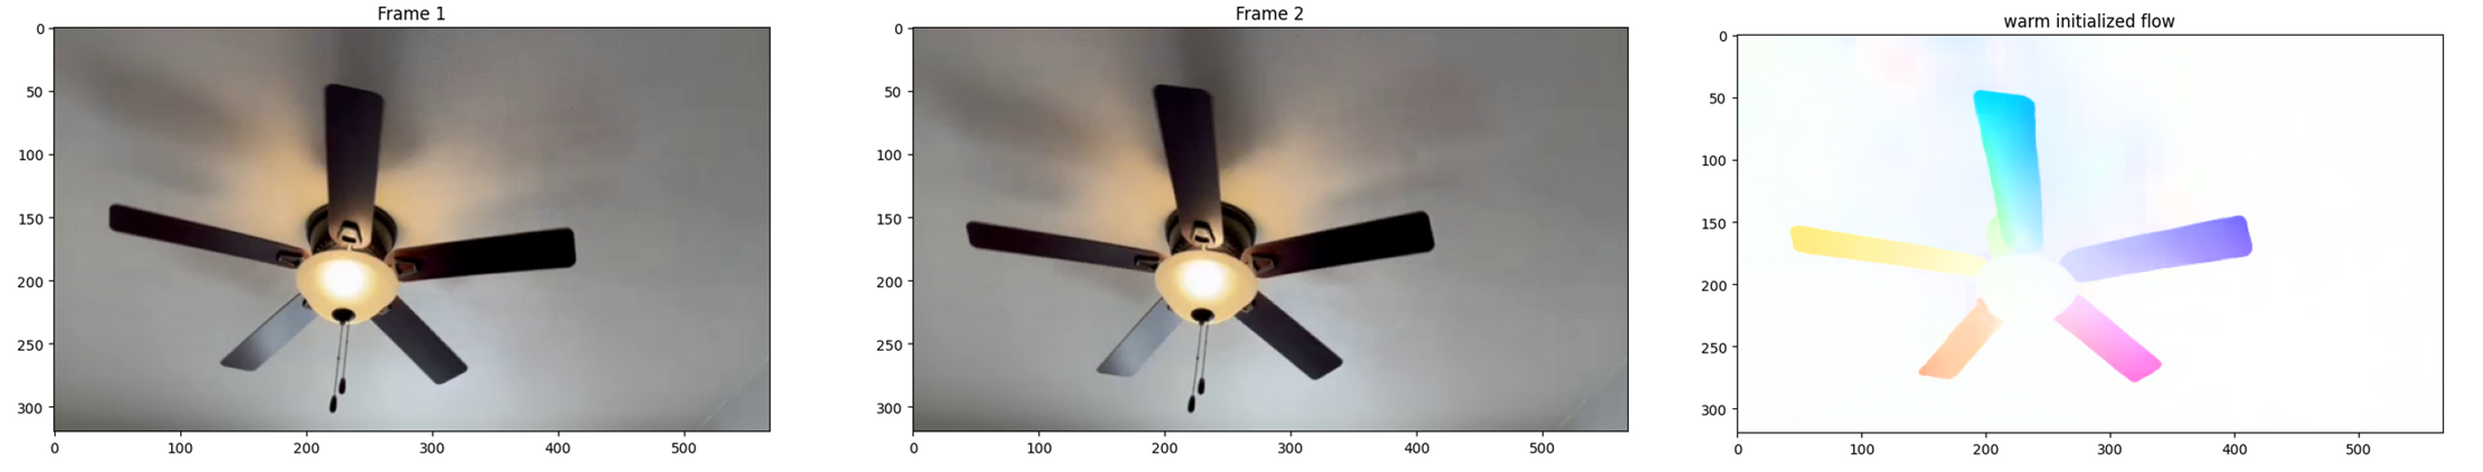

Get RAFT

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 17.90 MiB/s, done.
Resolving deltas: 100% (57/57), done.


Get Helper functions

In [2]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/raft_utils.py

--2023-10-01 23:24:25--  https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/raft_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3637 (3.6K) [text/plain]
Saving to: ‘raft_utils.py’

raft_utils.py       100%[===================>]   3.55K  --.-KB/s    in 0s      

2023-10-01 23:24:26 (62.3 MB/s) - ‘raft_utils.py’ saved [3637/3637]



In [4]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# add RAFT core to the path
sys.path.append('RAFT/core')

from raft_utils import *

### Get Data

In [6]:
import subprocess

env = os.environ.copy()
frame_paths = []
for i in range(75):
    cmd = f"wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_{i}.png"
    subprocess.run(cmd, shell=True, env=env)

    frame_paths.append(f"fan_frame_{i}.png")

In [7]:
frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

### Download Models

In [8]:
%cd RAFT
!./download_models.sh
%cd ..

/content/RAFT
--2023-10-01 23:25:38--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.80.15, 2620:100:6031:15::a27d:510f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.80.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  17.2MB/s    in 6.6s    

2023-10-01 23:25:47 (11.8 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Load Model

In [9]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# **Run RAFT on Sequence of Images**

In this section we will run RAFT on the fan image sequence

In [10]:
# store results
unfiltered_flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2RGB)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2RGB)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      unfiltered_flow_frames.append(flow_up)

    unfiltered_flow_frames.append(flow_up_warm)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


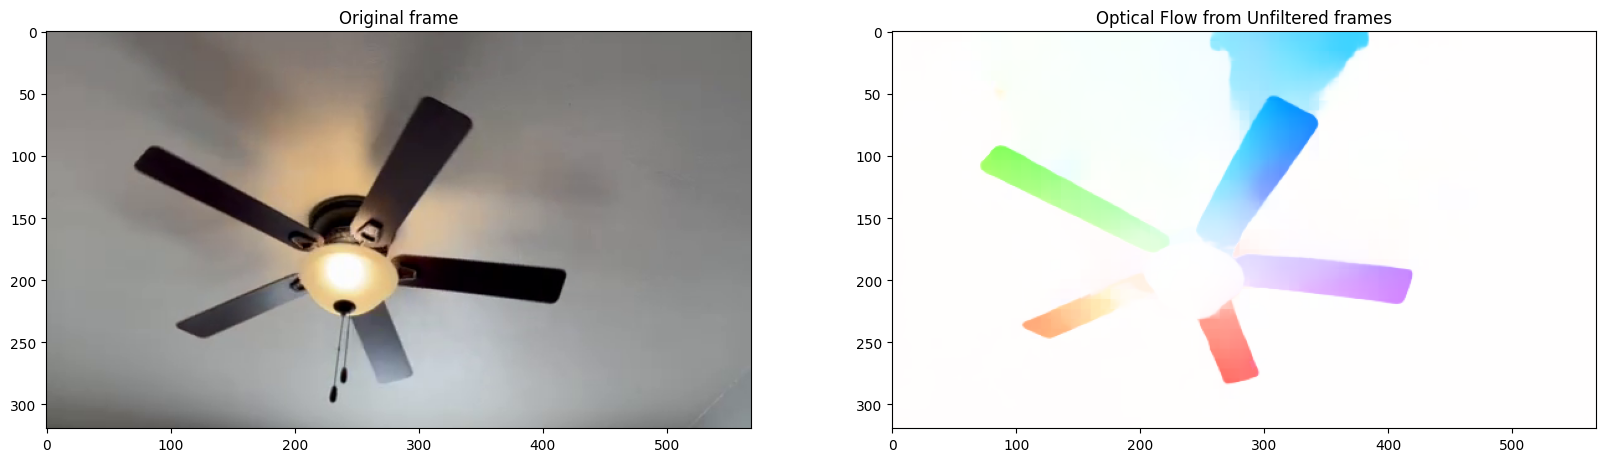

In [115]:
idx = 70

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
warm = unfiltered_flow_frames[idx].clone()

_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(og_frame)
ax[0].set_title('Original frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Optical Flow from Unfiltered frames');

# **Spatial Filtering**

The goal of this section is to remove the noise in the flow estimates, if you notice in the unfiltered estimates above, there is almost always some distorted flow that is erroenously being estimated. We will attempt to remove this noise with some simple Spatial Filtering, before and after the flow estimation.

<br>

Below is the code to filter the images before we estimate the flow, we are simply bluring, sharpening, and then bluring again for a set number of iterations. We also remove very small values (less than 10) as another way of reducing noise. We will see below that this method is able to extract the main parts of the image, removing most of the noise. We will also notice that the filtering is not perfect since it introduces small artifacts that are hard to get rid of.

In [20]:
def filter_image(frame, iters=1):

    filtered = frame.copy()

    for i in range(iters):
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(3,3), sigmaX=3)
      filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
      filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(5,5), sigmaX=5)
      filtered[filtered < 10] = 0
      filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=10, beta=0)

    return filtered

In [21]:
# store results
cold_flow_frames = []
flow_frames = []

for i in range(2, len(frame_paths)):
    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

    # Filter
    frame_1 = filter_image(frame_1, iters=2)
    frame_2 = filter_image(frame_2, iters=2)
    frame_3 = filter_image(frame_3, iters=2)

    # repeat last 3 dimensions
    frame_1 = np.repeat(frame_1[:, :, None], 3, axis=-1)
    frame_2 = np.repeat(frame_2[:, :, None], 3, axis=-1)
    frame_3 = np.repeat(frame_3[:, :, None], 3, axis=-1)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    if i == 2:
      flow_frames.append(flow_up)
      cold_flow_frames.append(flow_up)

    flow_frames.append(flow_up_warm)
    cold_flow_frames.append(flow_up_cold)


Display results, this time we will filter small values from the flow estimates. Try different values for 'thresh' and see how it impacts the flow estimates

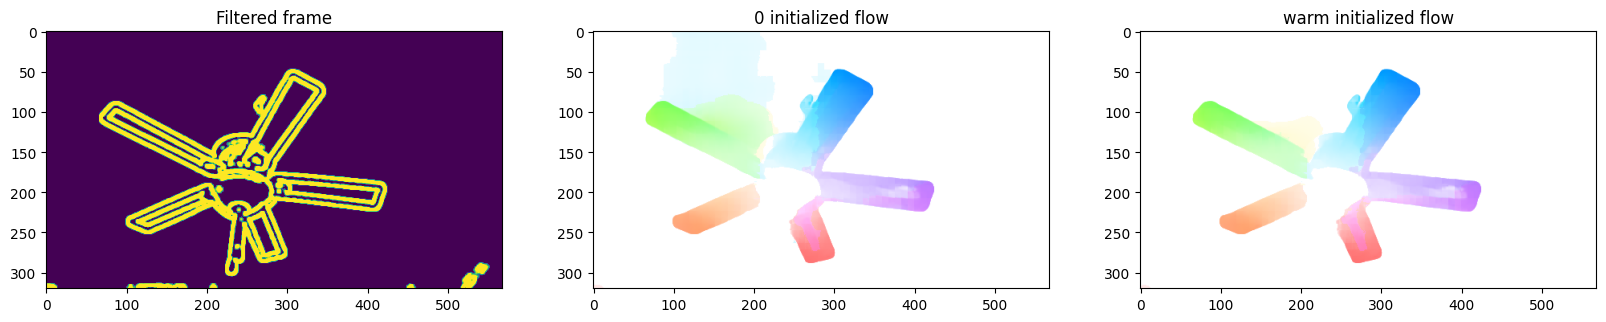

In [110]:
# filter results
idx = 70
thresh = 2

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

cold = cold_flow_frames[idx].clone()
cold[torch.abs(cold) < thresh] = 0

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

f, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(cold))
ax[1].set_title('0 initialized flow')
ax[2].imshow(get_viz(warm))
ax[2].set_title('warm initialized flow');

Now let's visualize everything

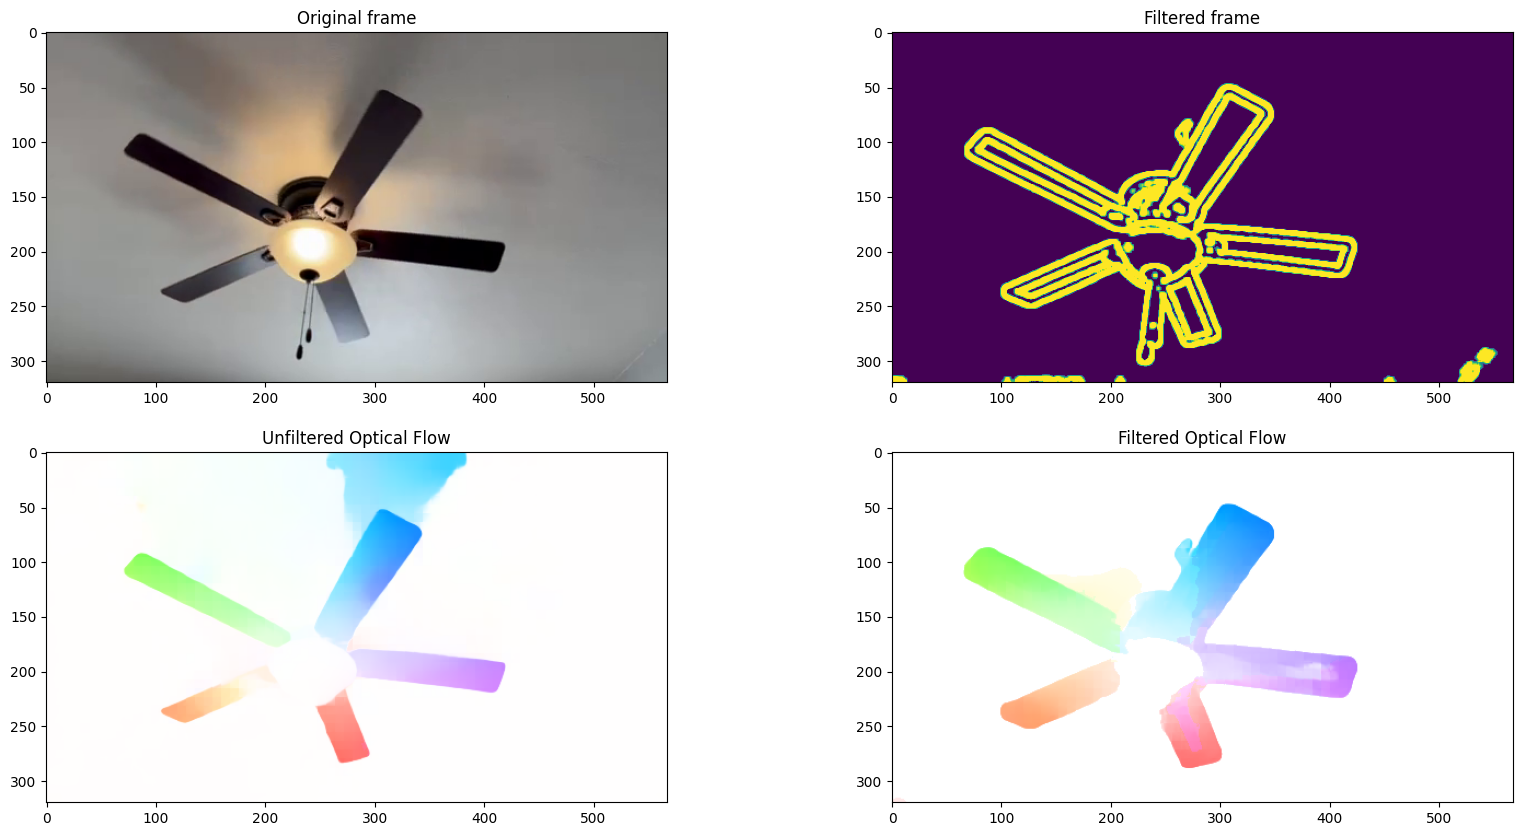

In [116]:
idx = 70
thresh = 2

un_flow = unfiltered_flow_frames[idx].clone()

flow = flow_frames[idx].clone()
flow[torch.abs(flow) < thresh] = 0

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0, 0].imshow(og_frame)
ax[0, 0].set_title('Original frame')
# ax[0, 0].axis(False)

ax[0, 1].imshow(frame)
ax[0, 1].set_title('Filtered frame')
# ax[0, 1].axis(False)

ax[1, 0].imshow(get_viz(un_flow))
ax[1, 0].set_title('Unfiltered Optical Flow');
# ax[1, 0].axis(False);

ax[1, 1].imshow(get_viz(flow))
ax[1, 1].set_title('Filtered Optical Flow');
# ax[1, 1].axis(False);

We see that the warm initialized flow seems to perform a bit better so we will use that moving forward. Now let's make a GIF of what we have, this will allow us to get better insight of the benefits of Spatial Filtering.

In [222]:
from PIL import Image
from glob import glob


def create_gif_from_images(save_path, image_path, ext):
    ''' creates a GIF from a folder of images
        Inputs:
            save_path (str) - path to save GIF
            image_path (str) - path where images are located
            ext (str) - extension of the images
        Outputs:
            None

        Update:
            Add functionality for multiple extensions
    '''
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))

    pil_images = [Image.open(im_path ) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

In [223]:
thresh = 2


for i in range(len(flow_frames)):

    un_flow = unfiltered_flow_frames[i].clone()
    un_flow[torch.abs(un_flow) < thresh] = 0

    flow = flow_frames[i].clone()
    flow[torch.abs(flow) < thresh] = 0

    og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
    frame = filter_image(frame)
    frame = filter_image(frame)

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))

    ax[0, 0].imshow(og_frame)
    ax[0, 0].set_title('Original frame')
    ax[0, 0].axis(False)

    ax[0, 1].imshow(frame)
    ax[0, 1].set_title('Filtered frame')
    ax[0, 1].axis(False)

    ax[1, 0].imshow(get_viz(un_flow))
    ax[1, 0].set_title('Unfiltered Optical Flow');
    ax[1, 0].axis(False);

    ax[1, 1].imshow(get_viz(flow))
    ax[1, 1].set_title('Filtered Optical Flow');
    ax[1, 1].axis(False);

    fig.savefig(f"flow_gif_{i}.jpg");
    plt.close();

In [224]:
gif_frame_paths = sorted(glob('*.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'flow.gif'

In [225]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

# **Temporal Filtering**

In this section we will perform Temporal Filtering on each pixel of each estimate flow frame. We will try a few approaches

- Rolling average filter
- Rolling Median Filter
- Hampel Filter (Based on [Median Absolute Deviation (MAD)](https://en.wikipedia.org/wiki/Median_absolute_deviation))

The above methods are typically used on 1D data, we will need to parallize these operations

## **Rolling Average Filter**

NOTE: There will be end artifacts, we will need to account for this somehow

<br>
<br>

#### **Algorithm Outline:** <br>

Set n number of taps (number of temporal pixels to consider)
<br>

For each flow frame <br>
&emsp;&emsp; For each pixel location: <br>
 &emsp;&emsp; - take the magnitude of the flow vector <br>
 &emsp;&emsp; - collect n consecutive pixel samples <br>
 &emsp;&emsp; - Take the temporal average (t_avg) <br>
 &emsp;&emsp; - Compare each test pixel at n - n//2 with their temporal averages
 &emsp;&emsp; - If abs(test_pixel) > 3*abs(t_avg), then test_pixel = t_avg

In [189]:
n = 5          # number of taps
loc = n - n//2 # test pixel location
s = 5          # tunable scale factor

In [190]:
avg_filtered_flows = []
for i in range(n, len(flow_frames)):
    flow = torch.cat(flow_frames[i-n:i])
    # flow_norm = flow.norm(dim=1)

    # compute temporal average of magnitude of flow frames
    t_avg = flow.mean(dim=0)

    test_pixels = flow[loc, :, :, :]

    # remove pixels that are above the temporal average
    mask = torch.abs(test_pixels) > s*torch.abs(t_avg)
    test_pixels[mask] = t_avg[mask]

    avg_filtered_flows.append(test_pixels)


In [191]:
mask.shape, test_pixels.shape, t_avg.shape

(torch.Size([2, 320, 568]),
 torch.Size([2, 320, 568]),
 torch.Size([2, 320, 568]))

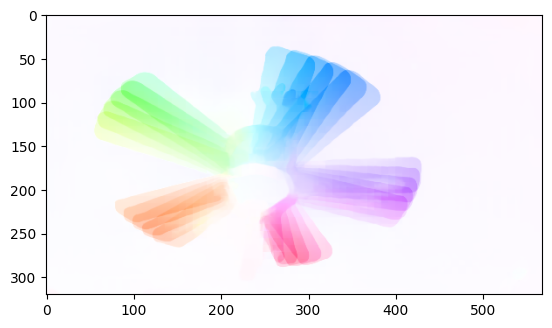

In [306]:
plt.imshow(get_viz(t_avg.unsqueeze(0)))

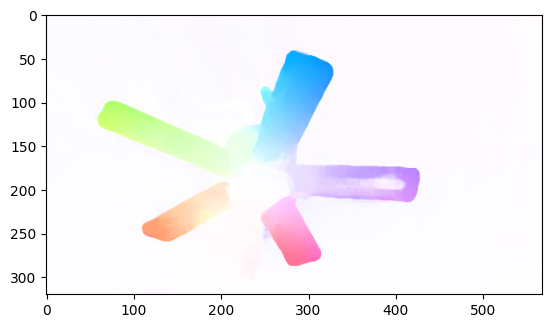

In [193]:
plt.imshow(get_viz(test_pixels.unsqueeze(0)))

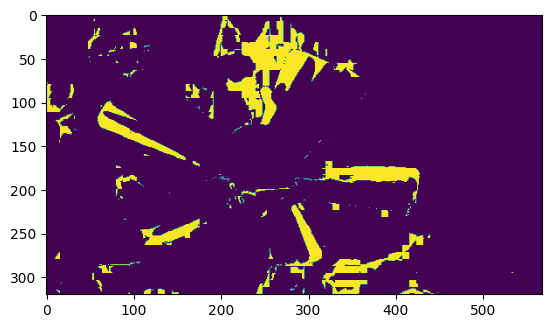

In [203]:
plt.imshow(mask[0, :, :].cpu().numpy())

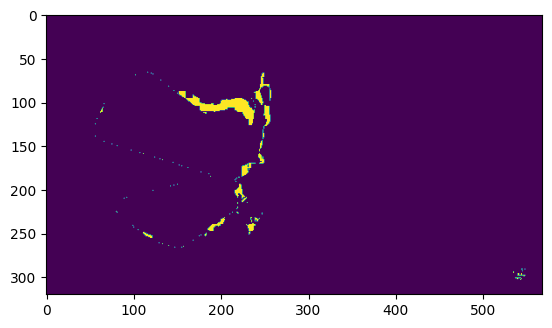

In [195]:
plt.imshow(mask[1, :, :].cpu().numpy())

Display Results

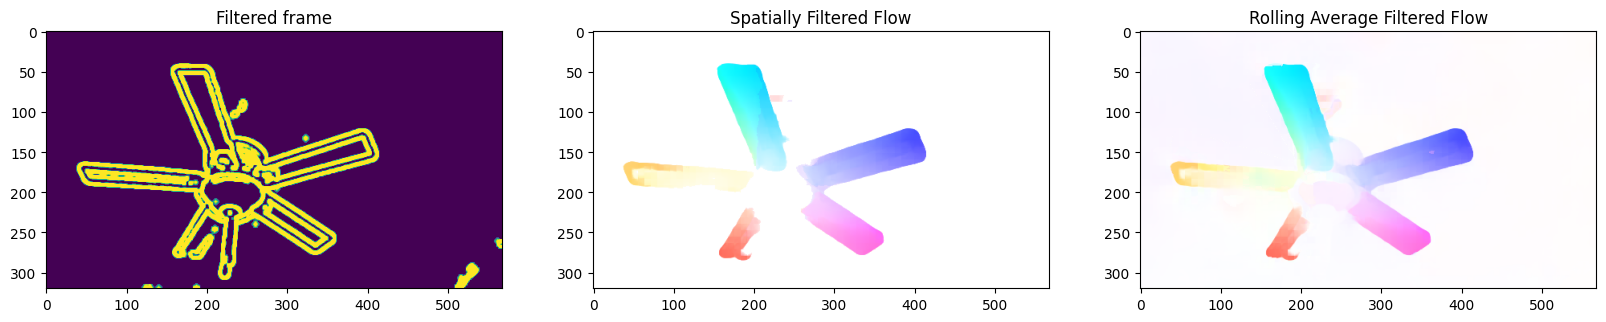

In [196]:
# filter results
idx = 27
thresh = 2

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

t_avg_flow = avg_filtered_flows[idx - loc]

_, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Spatially Filtered Flow')
ax[2].imshow(get_viz(t_avg_flow.unsqueeze(0)))
ax[2].set_title('Rolling Average Filtered Flow');

## **Median Average Filter**

In [212]:
n = 3          # number of taps
loc = n - n//2 # test pixel location
s = 5          # tunable scale factor

In [213]:
med_filtered_flows = []
for i in range(n, len(flow_frames)):
    flow = torch.cat(flow_frames[i-n:i])

    # compute temporal median of magnitude of flow frames
    t_med = flow.median(dim=0)[0]

    test_pixels = flow[loc, :, :, :]

    # remove pixels that are above the temporal average
    mask = torch.abs(test_pixels) > s*torch.abs(t_med)
    mask = torch.logical_and(mask[0, :, :], mask[1, :, :]).repeat(2, 1, 1)

    test_pixels[mask] = t_med[mask]

    med_filtered_flows.append(test_pixels)

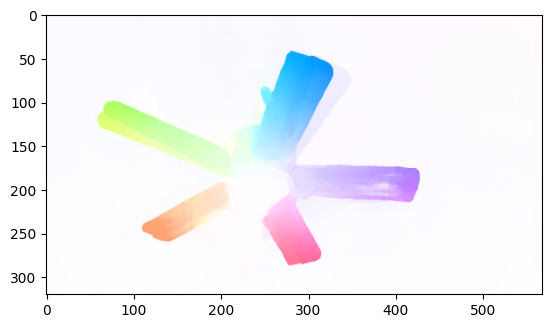

In [221]:
plt.imshow(get_viz(t_med.unsqueeze(0)))

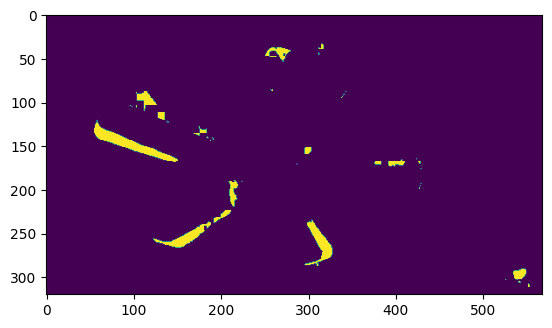

In [214]:
plt.imshow(mask[0, :, :].cpu().numpy())

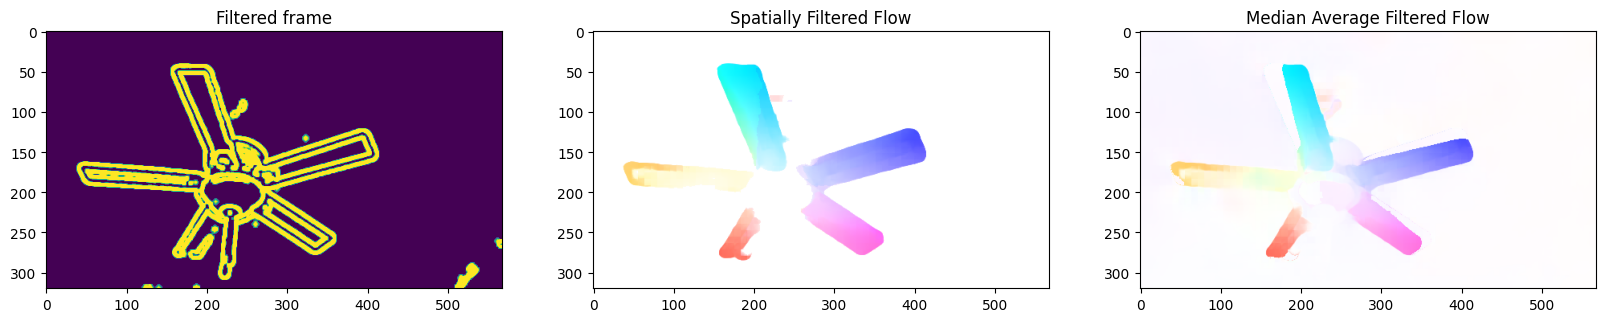

In [218]:
# filter results
idx = 27
thresh = 2

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

t_med_flow = med_filtered_flows[idx - loc]

_, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Spatially Filtered Flow')
ax[2].imshow(get_viz(t_med_flow.unsqueeze(0)))
ax[2].set_title('Median Average Filtered Flow');

# **Hampel Filter**

ref: https://asp-eurasipjournals.springeropen.com/articles/10.1186/s13634-016-0383-6

In [332]:
n = 3          # number of taps
loc = n - n//2 # test pixel location
t = 3          # tunable scale factor

In [387]:
hampel_filtered_flows = []
for i in range(n, len(flow_frames)):

    # capture moving flow window
    flow = torch.cat(flow_frames[i-n:i])
    # flow = torch.cat(flow_frames[i-n:i-n//2 -1] + flow_frames[i - n//2 : i])

    # get pixels under test
    x = flow[loc, :, :, :]
    # x = flow_frames[i - n//2 - 1].clone().squeeze(0)

    # # remove test pixels from moving flow window
    # flow = torch.cat(flow_frames[i-n:], flow_frames[:i])

    # compute median of moving flow window
    med = flow.median(dim=0)[0]

    # compute MAD scale factor
    s = 1.4826 * (flow - med).median(dim=0)[0]

    # perform filtering
    mask = torch.abs(x - med) > t*s


    # # remove pixels that are above the temporal average
    # mask = torch.abs(test_pixels) > s*torch.abs(t_med)
    # mask = torch.logical_and(mask[0, :, :], mask[1, :, :]).repeat(2, 1, 1)

    x[mask] = med[mask]

    hampel_filtered_flows.append(x)

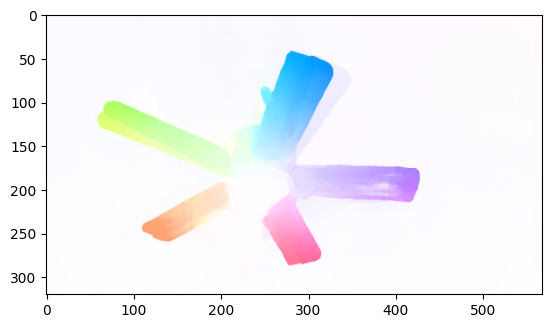

In [388]:
plt.imshow(get_viz(med.unsqueeze(0)))

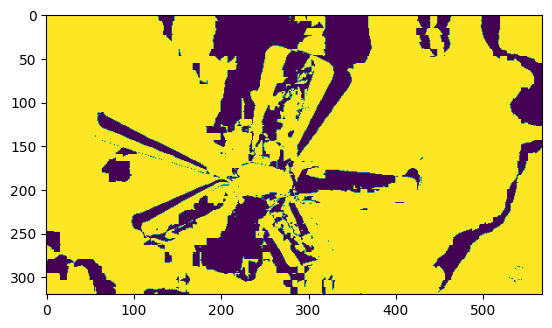

In [389]:
plt.imshow(mask[0, :, :].cpu().numpy())

In [390]:
i - n, i - n//2 - 1, i - n//2, i, i - n//2 - 1

(70, 71, 72, 73, 71)

In [391]:
len(flow_frames[i-n:i-n//2 -1]), len(flow_frames[i - n//2 : i])

(1, 1)

In [392]:
torch.cat(flow_frames[i-n:i-n//2 -1] + flow_frames[i - n//2 : i]).shape

torch.Size([2, 2, 320, 568])

In [393]:
flow.shape, med.shape, s.shape, mask.shape

(torch.Size([3, 2, 320, 568]),
 torch.Size([2, 320, 568]),
 torch.Size([2, 320, 568]),
 torch.Size([2, 320, 568]))

In [394]:
(flow - med).median(dim=0)[0].shape

torch.Size([2, 320, 568])

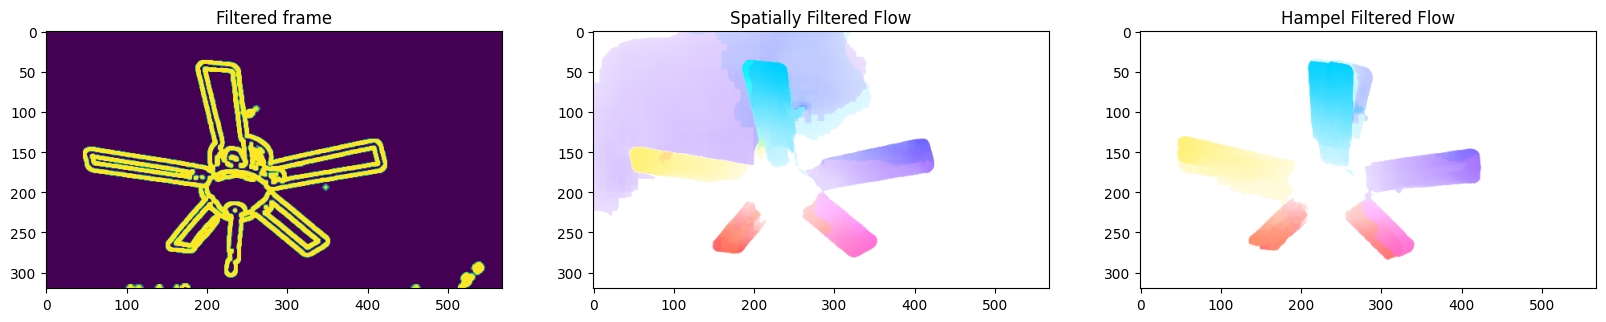

In [399]:
# filter results
idx = 50
thresh = 3

og_frame = cv2.cvtColor(cv2.imread(frame_paths[idx]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
frame = filter_image(frame)
frame = filter_image(frame)

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < thresh] = 0

filtered_flow = hampel_filtered_flows[idx - loc].clone()
filtered_flow[torch.abs(filtered_flow) < thresh] = 0

fig, ax = plt.subplots(1, 3, figsize=(20,10))

ax[0].imshow(frame)
ax[0].set_title('Filtered frame')
ax[1].imshow(get_viz(warm))
ax[1].set_title('Spatially Filtered Flow')
ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
ax[2].set_title('Hampel Filtered Flow');

### Create GIF

In [400]:
len(hampel_filtered_flows), len(flow_frames) - n

(71, 71)

In [401]:
loc

2

In [402]:
thresh = 2


for i in range(n, len(flow_frames)):

    og_frame = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)
    frame = cv2.cvtColor(og_frame, cv2.COLOR_RGB2GRAY)
    frame = filter_image(frame)
    frame = filter_image(frame)

    warm = flow_frames[i].clone()
    warm[torch.abs(warm) < thresh] = 0

    filtered_flow = hampel_filtered_flows[i - loc].clone()
    filtered_flow[torch.abs(filtered_flow) < thresh] = 0

    fig, ax = plt.subplots(1, 3, figsize=(20,10))

    ax[0].imshow(frame)
    ax[0].set_title('Filtered frame')
    ax[1].imshow(get_viz(warm))
    ax[1].set_title('Spatially Filtered Flow')
    ax[2].imshow(get_viz(filtered_flow.unsqueeze(0)))
    ax[2].set_title('Hampel Filtered Flow');

    fig.savefig(f"flow_gif_{i}_2.jpg");
    plt.close();

IndexError: ignored

In [403]:
gif_frame_paths = sorted(glob('*_2.jpg'))
gif_frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
gif_path = 'flow_3.gif'

In [404]:
pil_images = [Image.open(im_path) for im_path in gif_frame_paths]
pil_images[0].save(gif_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)